In [15]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset

#Converting Strings to datetime
def parser(x):
	return datetime.strptime('20'+x, '%Y-%m')
series = read_csv('2020Tourists.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


# frame a sequence as a supervised learning problem

#The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

#For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df



<ipython-input-15-09bc5e777f53>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [16]:
#Calculating Difference between series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


In [17]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [18]:
#Values must be calculated on the training dataset and applied to scale the test dataset and any forecasts.

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


In [19]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [20]:
#The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


In [21]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [22]:
# load dataset
series = read_csv('2020Tourists.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [23]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


In [24]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values


In [25]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]


In [26]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [27]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


array([[ 6.26337379e-02],
       [-8.83626714e-02],
       [-3.35349888e-03],
       [ 3.63357067e-02],
       [ 2.89402083e-02],
       [-2.88252905e-02],
       [ 3.10429111e-02],
       [-1.20343365e-01],
       [-6.36358038e-02],
       [-1.45352572e-01],
       [-2.89865613e-01],
       [-1.61191374e-01],
       [-1.99157968e-02],
       [-9.89846885e-05],
       [ 5.79149276e-03],
       [ 2.86065452e-02],
       [ 5.88751435e-02],
       [-1.24856010e-02],
       [ 3.40907238e-02],
       [-1.66178137e-01],
       [-1.18210040e-01],
       [-2.28820175e-01],
       [-2.56618351e-01],
       [-1.01682998e-01],
       [-5.23846671e-02],
       [-8.50725919e-04],
       [ 4.64474186e-02],
       [-3.97504866e-03],
       [ 4.31409851e-02],
       [-5.04799932e-03],
       [ 3.49555686e-02],
       [-5.75198606e-02],
       [-1.01442643e-01],
       [-2.45778948e-01],
       [-3.33489567e-01],
       [-1.31796330e-01],
       [-8.96377638e-02],
       [ 2.27272324e-02],
       [-2.5

In [28]:
# walk-forward validation on the test data

predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=1611078.140110, Expected=1787435.000000
Month=2, Predicted=1746084.880961, Expected=1773112.000000
Month=3, Predicted=1949991.863913, Expected=718097.000000
Month=4, Predicted=329089.002601, Expected=24238.000000
Month=5, Predicted=-1030337.754512, Expected=29238.000000
Month=6, Predicted=506358.811654, Expected=214789.000000
Month=7, Predicted=658955.923353, Expected=932927.000000
Month=8, Predicted=1413343.991736, Expected=1814701.000000
Month=9, Predicted=2256815.781878, Expected=2203482.000000
Month=10, Predicted=2822206.397064, Expected=1742303.000000
Month=11, Predicted=855134.772993, Expected=1262757.000000
Month=12, Predicted=583252.789739, Expected=964816.000000


Test RMSE: 616912.665


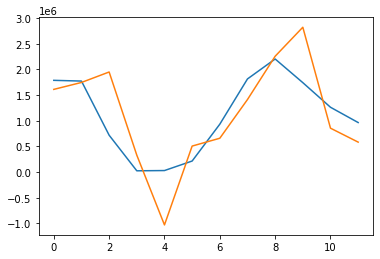

In [29]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

#Orange line is Predicted values

#Blue line is Expected values